In [1]:
import pandas as pd
import numpy as np
import math
import time
import random
import re
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('Corona_train.csv')
df.rename(columns={'CoronaTweet':'Tweet'}, inplace=True)
print(df)

          ID Sentiment                                              Tweet
0      22979  Positive  I see all kinds of academics already whipping ...
1       9880  Negative  @HenrySmithUK can you raise with Boris please ...
2      35761  Negative  It s a confusing odd time for the shopping pub...
3      37968  Positive  Blog Summary: The Impact of COVID-19 on the Ca...
4      19709   Neutral  ??????? ??????? ???\r\r\nWaiting in a long Que...
...      ...       ...                                                ...
37859  20253   Neutral  DOUBLE TAP ??IF YOU REMEMBER BEING EMPLOYED?\r...
37860  38926  Positive  Struggling to understand why supermarkets or f...
37861  35889  Positive  For anyone interested in the checklist on cons...
37862  40641  Positive  Do you agree with the hypothesis that Indian s...
37863  26063   Neutral  In Richmond, local boutiques and thrift stores...

[37864 rows x 3 columns]


In [10]:
target_df_1 = pd.read_csv('Twitter_train_1.csv')
df_1 = pd.concat([df, target_df_1])

target_df_2 = pd.read_csv('Twitter_train_2.csv')
df_2 = pd.concat([df, target_df_2])

target_df_5 = pd.read_csv('Twitter_train_5.csv')
df_5 = pd.concat([df, target_df_5])

target_df_10 = pd.read_csv('Twitter_train_10.csv')
df_10 = pd.concat([df, target_df_10])

target_df_25 = pd.read_csv('Twitter_train_25.csv')
df_25 = pd.concat([df, target_df_25])

target_df_50 = pd.read_csv('Twitter_train_50.csv')
df_50 = pd.concat([df, target_df_50])

target_df_100 = pd.read_csv('Twitter_train_100.csv')
df_100 = pd.concat([df, target_df_100])

In [4]:
def stopword_stemming(tweet_list):
    stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "you're", "you've", "you'll", "you'd", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's", "her", "hers", "herself", "it", "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "that'll", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "don't", "should", "should've", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"]
    tweet_list_stop = [w for w in tweet_list if not w.lower() in stopwords]
    for i in range(0, len(tweet_list_stop)):
        if(tweet_list_stop[i].endswith("ing")):
            str_name = tweet_list_stop[i]
            tweet_list_stop[i] = str_name[ :len(str_name)-len("ing") ]
        if(tweet_list_stop[i].endswith("ed")):
            str_name = tweet_list_stop[i]
            tweet_list_stop[i] = str_name[ :len(str_name)-len("ed") ]

    return tweet_list_stop

def vocabulary(x, mode):
    if mode==0:
        vocab = {}
        for tweet in x:
            tweet_list = list()
            tweet_list = re.split('\r|\n|\s|\t|\!|\?|\.|\#|\,|\:', tweet.lower())
            for words in stopword_stemming(tweet_list):
                if(words != "" and words in vocab.keys()):
                    vocab.update({words:vocab[words]+1})
                elif(words != ""):
                    vocab[words] = 1
                else:
                    continue
    return vocab

In [5]:
def log_prob_priori(y):
    positive = math.log(y.loc[y == 'Positive'].shape[0]/y.shape[0])
    negative = math.log(y.loc[y == 'Negative'].shape[0]/y.shape[0])
    neutral = math.log(y.loc[y == 'Neutral'].shape[0]/y.shape[0])
    return [positive, negative, neutral]

def log_prob_posteriori(test_tweet, label, alpha, df, no_of_words, vocab, v):
    df_label = df.loc[df['Sentiment'] == label]
    final_sum = 0
    for word in stopword_stemming(re.split('\r|\n|\s|\t|\!|\?|\.|\#|\,|\:', test_tweet)):
        if(word != '' and word in vocab.keys()):
            sum_label = alpha + vocab[word]
        elif(word != ''):
            sum_label = alpha
        else:
            continue
        #final_sum += math.log(sum_label/(df_label.shape[0] + alpha*3))
        final_sum += math.log(sum_label/(no_of_words[label] + len(v)))
    return final_sum

def NaiveBayes(df, df_test, alpha):
    no_of_words = {}
    for label in ['Positive', 'Negative', 'Neutral']:
        df_label = df.loc[df['Sentiment'] == label]['Tweet']
        c = 0
        for tweet in df_label:
            lst = []
            lst = stopword_stemming(re.split('\r|\n|\s|\t|\!|\?|\.|\#|\,|\:', tweet))
            if '' in lst: lst.remove('')
            c += len(lst)
        no_of_words[label] = c

    vocab_pos = vocabulary(df.loc[df['Sentiment'] == 'Positive']['Tweet'], 0)
    vocab_neg = vocabulary(df.loc[df['Sentiment'] == 'Negative']['Tweet'], 0)
    vocab_neu = vocabulary(df.loc[df['Sentiment'] == 'Neutral']['Tweet'], 0)
    v = vocabulary(df['Tweet'], 0)

    labels = ['Positive', 'Negative', 'Neutral']
    predicted_label = list()
    log_priori = log_prob_priori(df['Sentiment'])
    prob_y = list()
    for tweet in df_test['Tweet']:
        max_predict = list()
        for label in labels:
            vocab = {}
            if(label == 'Positive'):
                vocab = vocab_pos
            elif(label == 'Negative'):
                vocab = vocab_neg
            else:
                vocab = vocab_neu
            max_predict.append(math.exp(log_prob_posteriori(tweet.lower(), label, alpha, df, no_of_words, vocab, v) + log_priori[labels.index(label)]))
        prob_y.append(max_predict)
        predicted_label.append(labels[max_predict.index(max(max_predict))])
    return prob_y, predicted_label

In [6]:
def accuracy(prediction, real):
    correct = 0
    for i in range(0, len(prediction)):
        if(prediction[i] == real[i]):
            correct += 1
    return correct/len(prediction)

In [7]:
df_test = pd.read_csv('Twitter_validation.csv')
accuracies = list()

prob_y_given_x_1, prediction_1 = NaiveBayes(df_1, df_test, 1)
accuracies.append(accuracy(prediction_1, df_test['Sentiment'].values.tolist()))

prob_y_given_x_2, prediction_2 = NaiveBayes(df_2, df_test, 1)
accuracies.append(accuracy(prediction_2, df_test['Sentiment'].values.tolist()))

prob_y_given_x_5, prediction_5 = NaiveBayes(df_5, df_test, 1)
accuracies.append(accuracy(prediction_5, df_test['Sentiment'].values.tolist()))

prob_y_given_x_10, prediction_10 = NaiveBayes(df_10, df_test, 1)
accuracies.append(accuracy(prediction_10, df_test['Sentiment'].values.tolist()))

prob_y_given_x_25, prediction_25 = NaiveBayes(df_25, df_test, 1)
accuracies.append(accuracy(prediction_25, df_test['Sentiment'].values.tolist()))

prob_y_given_x_50, prediction_50 = NaiveBayes(df_50, df_test, 1)
accuracies.append(accuracy(prediction_50, df_test['Sentiment'].values.tolist()))

prob_y_given_x_100, prediction_100 = NaiveBayes(df_100, df_test, 1)
accuracies.append(accuracy(prediction_100, df_test['Sentiment'].values.tolist()))


In [11]:
accuracies_target = list()

prob_y_given_x_target_1, prediction_target_1 = NaiveBayes(target_df_1, df_test, 1)
accuracies_target.append(accuracy(prediction_target_1, df_test['Sentiment'].values.tolist()))

prob_y_given_x_target_2, prediction_target_2 = NaiveBayes(target_df_2, df_test, 1)
accuracies_target.append(accuracy(prediction_target_2, df_test['Sentiment'].values.tolist()))

prob_y_given_x_target_5, prediction_target_5 = NaiveBayes(target_df_5, df_test, 1)
accuracies_target.append(accuracy(prediction_target_5, df_test['Sentiment'].values.tolist()))

prob_y_given_x_target_10, prediction_target_10 = NaiveBayes(target_df_10, df_test, 1)
accuracies_target.append(accuracy(prediction_target_10, df_test['Sentiment'].values.tolist()))

prob_y_given_x_target_25, prediction_target_25 = NaiveBayes(target_df_25, df_test, 1)
accuracies_target.append(accuracy(prediction_target_25, df_test['Sentiment'].values.tolist()))

prob_y_given_x_target_50, prediction_target_50 = NaiveBayes(target_df_50, df_test, 1)
accuracies_target.append(accuracy(prediction_target_50, df_test['Sentiment'].values.tolist()))

prob_y_given_x_target_100, prediction_target_100 = NaiveBayes(target_df_100, df_test, 1)
accuracies_target.append(accuracy(prediction_target_100, df_test['Sentiment'].values.tolist()))


In [12]:
print(accuracies)

[0.4821073558648111, 0.49502982107355864, 0.5119284294234593, 0.5291583830351226, 0.5215374420145792, 0.5420808482438702, 0.46288933068257127]


In [ ]:
#prob_y_given_x, prediction = NaiveBayes(df, df_test, 1)
#acc = accuracy(prediction, df_test['Sentiment'].values.tolist())

In [13]:
print(accuracies_target)

[0.35719019218025183, 0.3949635520212061, 0.43870112657389, 0.475480450629556, 0.4907223326706428, 0.5099403578528827, 0.5473823724320742]


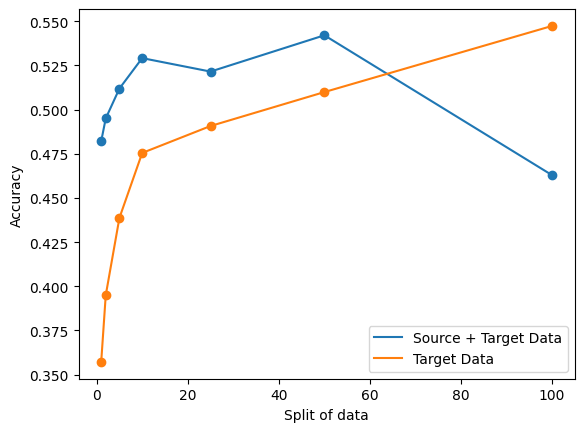

In [16]:
plt.plot([1, 2, 5, 10, 25, 50, 100], accuracies, label='Source + Target Data')
plt.scatter([1, 2, 5, 10, 25, 50, 100], accuracies)
plt.plot([1, 2, 5, 10, 25, 50, 100], accuracies_target, label='Target Data')
plt.scatter([1, 2, 5, 10, 25, 50, 100], accuracies_target)
#plt.axhline(y = acc, color = 'g', linestyle = '-')
plt.legend(loc='lower right')
plt.xlabel('Split of data')
plt.ylabel('Accuracy')
plt.show()